# compute spectra on mitgcm outputs

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.192:8786 Dashboard: http://10.148.0.192:8787/status,Cluster Workers: 8 Cores: 112 Memory: 800.00 GB


--- 

# 1. load data_Eta

In [6]:
v = 'Eta'

face = 1

## open files, nc files
ncdata_dir = scratch+'/mit_nc/'
# search for right files, for example: Eta_f01_t*.nc
print(ncdata_dir)

/home1/scratch/xyu/mit_nc/


In [7]:
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

Number of files available: 5
Number of files processed: 2
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 ...
    rA       (i, j) float32 ..

In [8]:
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
print(ds)

CPU times: user 40 ms, sys: 16 ms, total: 56 ms
Wall time: 55.7 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 480), chunksize=(10, 432, 240)>


In [9]:
ds = ds.isel(time=slice(0,3000))

ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 .

In [10]:
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 132 ms, sys: 12 ms, total: 144 ms
Wall time: 500 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunks

In [11]:
%time Eta = ds['Eta'].persist()

CPU times: user 2.05 s, sys: 28 ms, total: 2.08 s
Wall time: 2.08 s


# 2. Eta_Spectral computations

_____

In [12]:
eta_fft = xrft.dft(Eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_eta = (eta_fft*eta_fft.conj()).where(eta_fft!=0., drop=False).mean(dim=('i','j'))
E_eta = E_eta.astype('f8').rename('Eta_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [13]:
%time E_eta.load()

CPU times: user 25.2 s, sys: 260 ms, total: 25.4 s
Wall time: 3min 2s


<xarray.DataArray 'Eta_power_spectrum ()' (freq_time: 480)>
array([5.928565e-10, 1.403779e+02, 2.312437e+02, ..., 8.740686e+01,
       2.312437e+02, 1.403779e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

______

# 1. Load data_SSU

In [16]:
v = 'SSU'

face = 1

## open files, nc files
ncdata_dir = scratch+'/mit_nc/'
# search for right files, for example: Eta_f01_t*.nc
print(ncdata_dir)

/home1/scratch/xyu/mit_nc/


In [17]:
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

Number of files available: 5
Number of files processed: 2
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 ...
    rA       (i, j) float32 ..

In [18]:
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
print(ds)

CPU times: user 52 ms, sys: 8 ms, total: 60 ms
Wall time: 326 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
Data variables:
    SSU      (i, j, time) float32 dask.array<shape=(4320, 4320, 480), chunksize=(10, 432, 240)>


In [19]:
ds = ds.isel(time=slice(0,3000))

ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 

In [20]:
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 134 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunks

In [21]:
%time SSU = ds['SSU'].persist()

CPU times: user 1.98 s, sys: 8 ms, total: 1.99 s
Wall time: 1.99 s


____

# 2. Load data_SSV

In [22]:
v = 'SSV'

face = 1

## open files, nc files
ncdata_dir = scratch+'/mit_nc/'
# search for right files, for example: Eta_f01_t*.nc
print(ncdata_dir)

/home1/scratch/xyu/mit_nc/


In [23]:
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

Number of files available: 5
Number of files processed: 2
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 ...
    rA       (i, j) float32 ..

In [24]:
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
print(ds)

CPU times: user 120 ms, sys: 4 ms, total: 124 ms
Wall time: 525 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
Data variables:
    SSV      (i, j, time) float32 dask.array<shape=(4320, 4320, 480), chunksize=(10, 432, 240)>


In [25]:
ds = ds.isel(time=slice(0,3000))

ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 

In [26]:
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 75.9 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksi

In [27]:
%time SSV = ds['SSV'].persist()

CPU times: user 2.02 s, sys: 8 ms, total: 2.02 s
Wall time: 2.03 s


_____

# 3. SSU and SSV_Spectral computations

In [28]:
##### SSU ####
u_fft = xrft.dft(SSU.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_u = (u_fft*u_fft.conj()).where(u_fft!=0., drop=False).mean(dim=('i','j'))
E_u = E_u.astype('f8').rename('SSU_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [29]:
%time E_u.load()

CPU times: user 28 s, sys: 420 ms, total: 28.4 s
Wall time: 5min 51s


<xarray.DataArray 'SSU_power_spectrum ()' (freq_time: 480)>
array([1.246877e-10, 3.415821e+02, 2.180307e+02, ..., 1.278310e+02,
       2.180307e+02, 3.415821e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

In [31]:
##### SSV ####
v_fft = xrft.dft(SSV.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_v = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i','j'))
E_v = E_v.astype('f8').rename('SSV_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [32]:
%time E_v.load()

CPU times: user 21.5 s, sys: 64 ms, total: 21.5 s
Wall time: 1min 41s


<xarray.DataArray 'SSV_power_spectrum ()' (freq_time: 480)>
array([8.442251e-11, 3.542141e+02, 2.383515e+02, ..., 1.337094e+02,
       2.383515e+02, 3.542141e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

# SST

_____

In [33]:
v = 'SST'

face = 1

## open files, nc files
ncdata_dir = scratch+'/mit_nc/'
# search for right files, for example: Eta_f01_t*.nc
print(ncdata_dir)

/home1/scratch/xyu/mit_nc/


In [34]:
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

Number of files available: 5
Number of files processed: 2
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 ...
    rA       (i, j) float32 ..

In [35]:
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
ds = ds.isel(time=slice(0,3000))

ds = xr.merge([ds,grid])

chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 132 ms, sys: 8 ms, total: 140 ms
Wall time: 354 ms
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 60.8 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [36]:
%time SST = ds['SST'].persist()

CPU times: user 1.98 s, sys: 4 ms, total: 1.99 s
Wall time: 1.99 s


In [37]:
##### SST ####
t_fft = xrft.dft(SST.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_t = (t_fft*t_fft.conj()).where(t_fft!=0., drop=False).mean(dim=('i','j'))
E_t = E_t.astype('f8').rename('SST_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [38]:
%time E_t.load()

CPU times: user 21.5 s, sys: 68 ms, total: 21.6 s
Wall time: 1min 40s


<xarray.DataArray 'SST_power_spectrum ()' (freq_time: 480)>
array([         inf, 1.857886e+27, 1.095794e+27, ..., 1.430608e+27,
       1.095794e+27, 1.857886e+27])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

# SSS
_____

In [39]:
v = 'SSS'

face = 1

## open files, nc files
ncdata_dir = scratch+'/mit_nc/'
# search for right files, for example: Eta_f01_t*.nc
print(ncdata_dir)

/home1/scratch/xyu/mit_nc/


In [40]:
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

Number of files available: 5
Number of files processed: 2
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 ...
    rA       (i, j) float32 ..

In [41]:
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
ds = ds.isel(time=slice(0,3000))

ds = xr.merge([ds,grid])

chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 148 ms, sys: 4 ms, total: 152 ms
Wall time: 328 ms
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 61.5 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [42]:
%time SSS = ds['SSS'].persist()

CPU times: user 2.04 s, sys: 12 ms, total: 2.05 s
Wall time: 2.05 s


In [43]:
##### SSS ####
s_fft = xrft.dft(SSS.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_s = (s_fft*s_fft.conj()).where(t_fft!=0., drop=False).mean(dim=('i','j'))
E_s = E_s.astype('f8').rename('SSS_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [44]:
%time E_s.load()

CPU times: user 26.7 s, sys: 304 ms, total: 27 s
Wall time: 4min 12s


<xarray.DataArray 'SSS_power_spectrum ()' (freq_time: 480)>
array([2.375066e-06, 1.504188e+04, 2.133520e+04, ..., 1.445670e+04,
       2.133520e+04, 1.504188e+04])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

______


# Plots

No handles with labels found to put in legend.


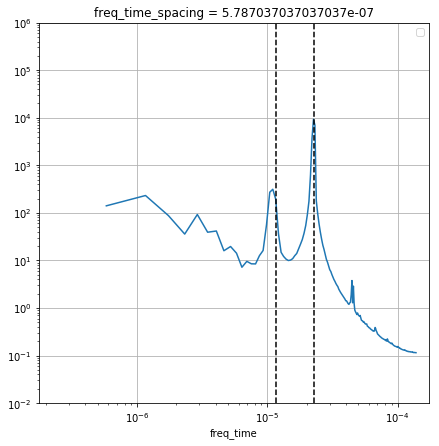

In [45]:
# Eta spectral plot

fig, ax = plt.subplots(figsize=(7,7))
E_eta.where(E_eta.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1.75*1e-7,1.75*1e-4])
ax.set_ylim([1e-2,1e6])

# M2 #
ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')

No handles with labels found to put in legend.


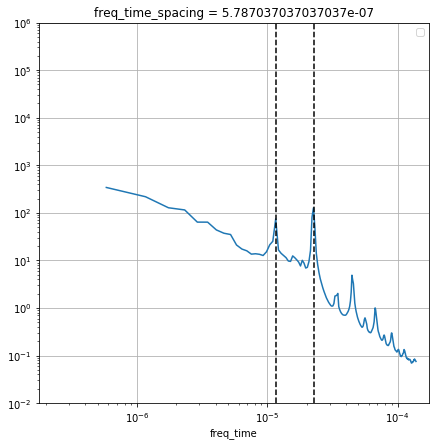

In [46]:
# SSU spectral plot

fig, ax = plt.subplots(figsize=(7,7))
E_u.where(E_u.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1.75*1e-7,1.75*1e-4])
ax.set_ylim([1e-2,1e6])

# M2 #
ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')

No handles with labels found to put in legend.


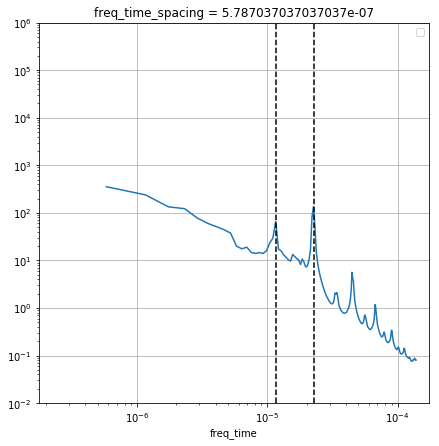

In [47]:
# SSV spectral plot

fig, ax = plt.subplots(figsize=(7,7))
E_v.where(E_v.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1.75*1e-7,1.75*1e-4])
ax.set_ylim([1e-2,1e6])

# M2 #
ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')


No handles with labels found to put in legend.


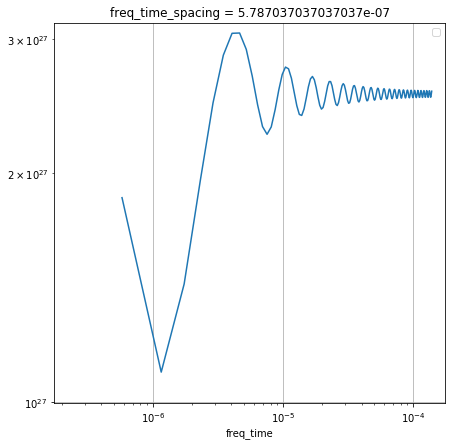

In [49]:
# SST spectral plot

fig, ax = plt.subplots(figsize=(7,7))
E_t.where(E_t.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1.75*1e-7,1.75*1e-4])
#ax.set_ylim([1e-2,1e6])

# M2 #
ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')

No handles with labels found to put in legend.


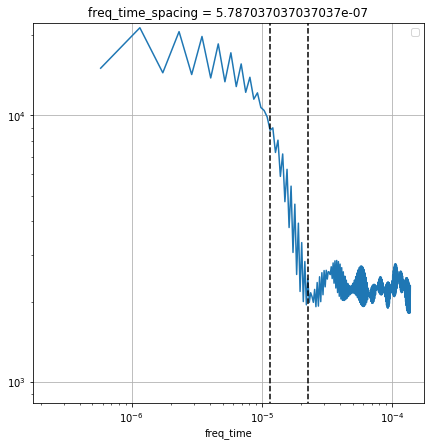

In [50]:
# SSS spectral plot

fig, ax = plt.subplots(figsize=(7,7))
E_s.where(E_s.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1.75*1e-7,1.75*1e-4])
#ax.set_ylim([1e-2,1e6])

# M2 #
ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


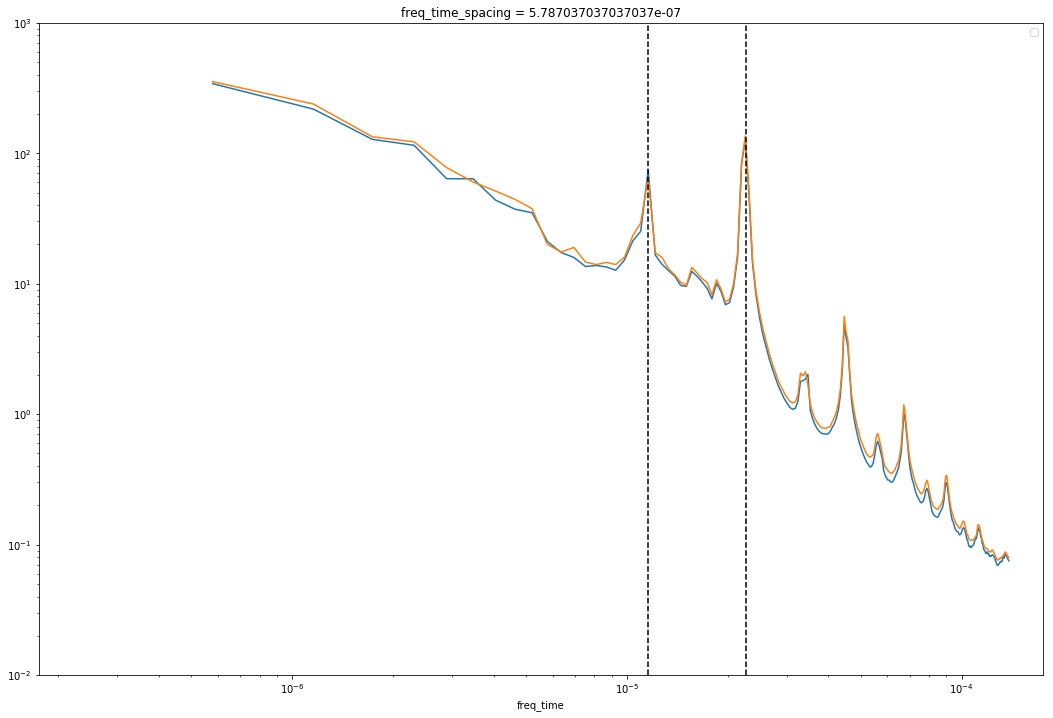

In [52]:
# SSU and SSV together

fig, ax = plt.subplots(figsize=(18,12))

# SSU
E_u.where(E_u.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1.75*1e-7,1.75*1e-4])
ax.set_ylim([1e-2,1e3])

# SSV
E_v.where(E_v.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 


# M2 #
ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


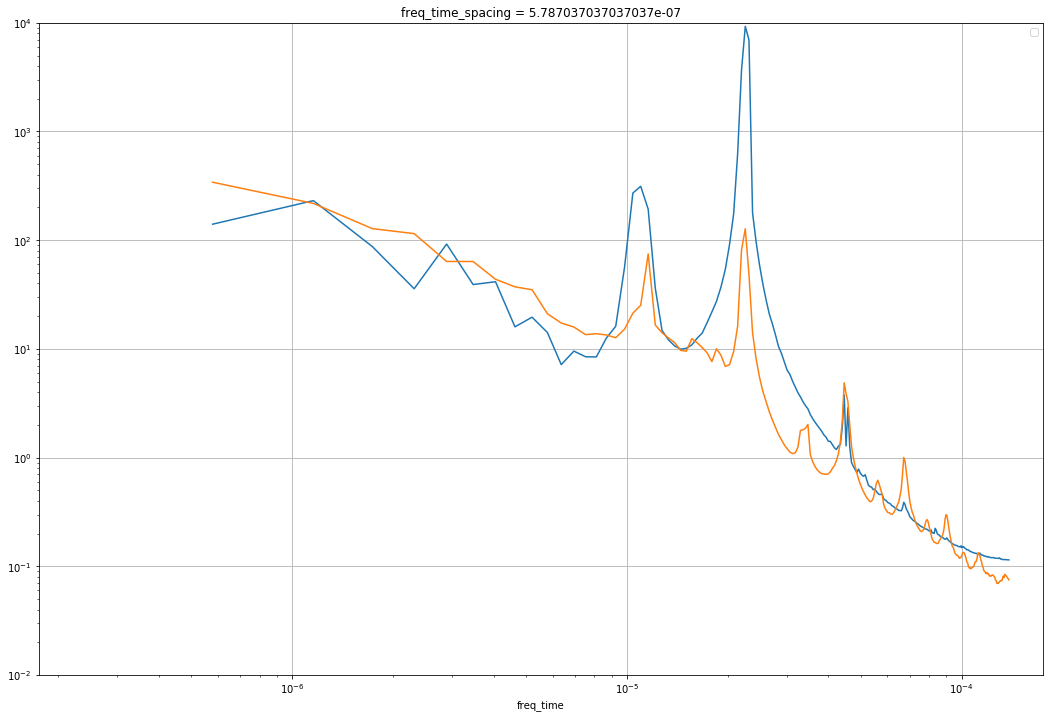

In [54]:
# together_spectral plot

fig, ax = plt.subplots(figsize=(18,12))

# Eta
E_eta.where(E_eta.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1.75*1e-7,1.75*1e-4])
ax.set_ylim([1e-2,1e4])

# SSU
E_u.where(E_u.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

# SST
E_t.where(E_t.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 



# M2 #
#ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
#ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')


---

In [55]:
client.restart()

Client Scheduler: tcp://10.148.0.192:8786 Dashboard: http://10.148.0.192:8787/status,Cluster Workers: 8 Cores: 112 Memory: 800.00 GB
